<a href="https://colab.research.google.com/github/Fabicca86/plantasBR/blob/main/_MyPlant_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BEM VIND@**

---

Este projeto busca criar um modelo de Deep Learning para reconhecimento/classificação, que retorna se uma planta pode ser encontrada na flora nativa brasileira.

# **Preparação dos Dados**

In [ ]:
import numpy as np
#from tensorflow.keras.datasets import mnist linha removida
import tensorflow as tf
import os #linha add para ler meu dataset

In [ ]:
cpus = tf.config.experimental.list_physical_devices('CPU')
#gpus = tf.config.experimental.list_physical_devices('GPU')
print(cpus)
#print(gpus)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [ ]:
#ERRO: MAS DIZEM Q NÃO PRECISA for cpu in cpus: #dizendoo ao tensor para limitar o usoo de memoria, usar só o necessário
  #tf.config.experimental.set_memory_growth(cpu,True)

###CRIANDO DATASET DO ZERO  
Em caso de estarmos criando um dataset do zero com imagens da internet, por exemplo google, podemos fazer uma pesquisa por imagens e com a extensão: download all images .zip  
Depois de baixados criamos a nossa pasta para continuarmos daqui
## TRATANDO AS IMAGENS  
#Removendo imagens duvidosas  
Precisamos ter certeza de que não temos imagens com estensão errada, corrompidas ou mau etiquetadas (não são, por exemplo, plantas e sim planta dos pés)   
Vamos excluir manualmente tudo que for menor que 10kb, estranho tipo html, exe, etc.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#criando o diretorio p salvar as img
!mkdir -p '/content/drive/MyDrive/data'



In [ ]:
import cv2
import imghdr
import matplotlib.pyplot as plt
#from matplotlib import pyplot as plt


wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.


In [ ]:
#criando a variável path para nosso diretório
data_dir='data'

In [ ]:
#verificandoo se chamamos o diretório correto, deve conter nossos classificadores exp: planta brasileira ou importadas(não)
#os.listdir(data_dir)
#os.listdir(os.path.join(data_dir, 'planta_br')) vai exibir todas as imagens contidas nessa pasta
#os.listdir(os.path.join(data_dir, 'planta_im')) vai exibir todas as imagens contidas nessa pasta

In [ ]:
#Verificando uma imagem com opencv e pyplot RODAR A CÉLULA SE QUISER VER COMO FUNCIONA
img=cv2.imread(os.path.join('data', 'planta_br', '1.jpg'))
#img.shape
#plt.imshow(img)

#cv2 lê os canais da imagem como BGR e pyplot espera RGB então modificamos isto com
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
#lista das extensões que queremos que permaneçam
valid_exts=['jpg','jpeg','png','bmp']
for img_class in os.listdir(data_dir):
  for img in os.listdir(os.path.join(data_dir,img_class)):
    img_path=os.path.join(data_dir,img_class,img)
    try:
      img=cv2.imread(img_path)
      ext=imghdr.what(img_path)
      if ext not in valid_exts:
        print(f'{img_path} has not a valid extension')
        os.remove(img_path)
    except Exception as e:
      print(f'Issue with image {img_path}')
# Voltar na pasta do computador e verificar a quantidade de imagens que restaram pois pode ser que
#ou o dataset ficou muito desbalanceado ou muito pobre em imagens

###CONSTRUINDO O PIPELINE DO TENSORFLOW  
Tensor já vem com uma API pipeline.  
Um pipeline de dados move os dados do ponto de coleta para o armazenamento, ou seja, extrai dados de uma fonte, faz alterações e os salva em um destino específico.  

Os pipelines de dados permitem integrar dados de diferentes fontes e transformá-los para análise. Eles removem silos de dados e tornam sua análise de dados mais confiável e precisa. Aqui estão alguns dos principais benefícios de um pipeline de dados.

#Melhor qualidade dos dados
Os pipelines de dados limpam e refinam os dados brutos, melhorando sua utilidade para os usuários finais. Eles padronizam formatos para campos como datas e números de telefone enquanto verificam erros de entrada. Eles também removem a redundância e garantem a qualidade consistente dos dados em toda a organização.

#Processamento eficiente de dados
Os engenheiros de dados precisam realizar muitas tarefas repetitivas enquanto transformam e carregam dados. Os pipelines de dados permitem que eles automatizem tarefas de transformação de dados e se concentrem em encontrar os melhores insights de negócios. Os pipelines de dados também ajudam os engenheiros de dados a processar mais rapidamente os dados brutos que perdem valor com o tempo.

#Integração de dados abrangente
Um pipeline de dados abstrai funções de transformação de dados para integrar conjuntos de dados de fontes diferentes. Ele pode cruzar valores dos mesmos dados de várias fontes e corrigir inconsistências. Por exemplo, imagine que o mesmo cliente faz uma compra em sua plataforma de comércio eletrônico e em seu serviço digital. No entanto, eles escrevem seu nome incorretamente no serviço digital. O pipeline pode corrigir essa inconsistência antes de enviar os dados para análise.  

Para uma consulta rápida

In [ ]:
tf.data.Dataset??
tf.keras.utils.image_dataset_from_directory??#apaga as ?? e coloca o nome da pasta ('data')
#Não vamos precisar criar as labels, as classes e parte do preprocessamento (split, reshape, batch)
#também o keras fará com o pipeline de dados

In [ ]:
#Pese a essa economia de esforço precisaremos iterar sobre as imagens uma a uma e para não ter de fazer isto manualmente
#pois supomos que temos uma quantidade massiva de dados criamos o batch para fazer esse loop contínuo para nós em nosso arquivo
#com os parametros do tf.keras.utils...
data_iterator=data.as_numpy_iterator()
batch=data_iterator.next()
#Legal verificar que oo len(batch) tenha 2 valores de tupla, o primeiro indicando as images e o segundo as labels
#todos como numpy arrays batch[0].shape (mostrará o numero de imagens or lote, pixels(tamanho) e canais(cor)
#batch[1].shape - labels numeradas como 32 arrays de 0 e 1.

In [ ]:
#Para ter certeza de qual label ficou para cada classificador podemos iterar sobre uma parte de um lote:
fig, ax =plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

###SCALING AND SPLITING  
Para otimizar o treino do nosso modelo podemos mudar o canal de RGB para escala de cinza, ou só passar a faixa de valor ppara algo entre zero e 1. Isto se deve a que quanto menor o valor menos erros e menos tempo para uma DLM aprender.
Imagens RGB são um array de 3 canais que vão de 0 - preto a 255 -branco = 256. Dividindo o batch[0]/255 nos retorna o que desejamos. Contudo, num pipeline não dá para fazer um loop (o inverso do pretendido com um pippeline), portanto, trabalharemos como a função MAP()

In [ ]:
data= data.map(lambda x,y: (x/255, y))
#Verificamos novamente as imagens e o shape delas sobre uma parte de um lote:
fig, ax =plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

SPLITTING

In [ ]:
#Vamos correr um  len para saber com quantos batches ficamos
len(data)



OBS nossoos dados já estão misturados - classificadores 1 e 0 mistos num batch. Se isto não tiver feito agora é a hora de shuffle
**For true randomness, we set the shuffle buffer to the full dataset size.
ds = ds.shuffle(ds_info.splits['train'].num_examples)**
Send ds o nome do dataset

In [ ]:
#é importante verificarmos que temos 60% train 20% test 20% validation
train_size = int(len(data)*.6) #+1 ou -1
val_size = int(len(data)*.2)
test_size = int(len(data)*.2)

#é legal chamar cada um ara verificar se  len batch bate como o train batch e etc se não bater deve ajustar +1 ou -1

In [ ]:
#take how many data we are taking in that particular partition
#and skip méthod skip the batches we already allocated in our trainning partition and take next ones
train =data.take(train_size)
val =data.skip(train_size).take(val_size)
test =data.skip(train_size+val_size).take(test_size)

#Building the model!!!

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
#Abaixo deixo o modelo da Facti mas é basicamente o mesmo com o código coonstruído diferente
model_tf = Sequential()


In [ ]:
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
# 16 filters with 3 by 3 pixels and 1 one stride- takes 1 pixel each time this can be modified, ex imagenet is different
#relu means that any output below 0 will be converted to zero and positive values will be left untouched -
#take on count non linear patterns

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu')) #dense= fully connected layers
model.add(Dense(1, activation='sigmoid'))#single output representing 0 oor 1
#model.add(Dense(10, activation='softmax')) TESTAR DEPOIS E VER SE HÁ DIFERENÇAS
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy']
#optimizer adam, binary cross entropy losses, metrics accuracy

In [ ]:
model.summary()

#Trainning

In [ ]:
log_dir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback]) #ele usou 20 epochs eu 10 para teste
#model fit - trainning component. You must loss reduce and accuracy get high
#hist.history #para acessar o logs

##Plot performance

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])#ease maybe should look at training data, is not learning or lot of bias, noise etc

fig=plot_figure
plt.plot(hist.history['loss'], color='magenta', label='loss')
plt.plot(hist.history['val_loss'], color='blue', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()
#o grafuco deve descer consistentemente, se oramr uma parabola indicara que pode haver um overfitting or if
#loss line dont increase maybe should look at training data, is not learning or lot of bias, noise etc

fig=plot_figure
plt.plot(hist.history['accuracy'], color='magenta', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='blue', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


#Evaluate performance

1.   from test



In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre=Precision()
re=Recall()
acc=BinaryAccuracy()

for batch in test.as_numpy_iterator():
  X, y=batch
  yhat=model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

In [ ]:
print(f'Precision: {pre.result().numpy()}, \n Recall:{re.result().numpy()} \n , Accuracy:{acc.result().numpy()}')

#Test

In [ ]:
#Baixar uma imagem exclusiva, que o modelo não tenha visto antes
#teste do teste

img=cv2.imread('imagem.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

tf.img.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
no.expand_dims(resize, 0)
yhat=model_predict(np.expand_dims(resize/255, 0))
#the neuralnet is waiting for us too uplooad a batch of img so we need to encapsulate it inside a arrays, set, nunmpy

In [ ]:
yhat
if yhat>.5:
  print(f'Predicted class is 1') #vamoos atualizar coonforme a classificação que obtivermos no inicio
else:
  print(f'Predicted class is 0')

#SAVE THE MODEL
fOR REUSE, DEPLOYMENT AS API OR TO EDGE DEVICE

In [ ]:
from tensorflow.keras.models import load_model
model.save(os.path.join('models','brazilian_plantsmodel.h5')) #CRIAR A PASTA MODELS - formato serial h5 tipo um zip


In [ ]:
#Reload the model and test again
new_model=load_model(os.path.join('models','brazilian_plantsmodel.h5'))


yhat_new=new_model.predict(np.expand_dims(resize/255, 0))
if yhat_new>.5:
  print(f'Predicted class is 1') #vamoos atualizar coonforme a classificação que obtivermos no inicio
else:
  print(f'Predicted class is 0')

  #FIM

In [ ]:
# Carregar dados do MNIST - do meu sistema OS
#(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Inspecionar a forma dos dados
#print("Forma dos dados de treino:", train_images.shape)
#print("Forma dos dados de teste:", test_images.shape)

# Normalização
#train_images = train_images / 255.0
#test_images = test_images / 255.0

# Remodelagem para adicionar o canal de cor
#train_images = train_images.reshape((-1, 28, 28, 1))
#test_images = test_images.reshape((-1, 28, 28, 1))


# **Construção de Modelo com TensorFlow**

## Desenvolvimento do Modelo

In [ ]:
# Construção do modelo
model_tf = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compilação do modelo
model_tf.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Treinamento e Avaliação

In [ ]:
# Treinamento do modelo
history_tf = model_tf.fit(train_images, train_labels, epochs=10, validation_split=0.2)

# Avaliação do modelo
test_loss, test_acc = model_tf.evaluate(test_images, test_labels)
print("Acurácia TensorFlow: ", test_acc
      )

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.8980 - loss: 0.3371 - val_accuracy: 0.9761 - val_loss: 0.0824
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - accuracy: 0.9828 - loss: 0.0582 - val_accuracy: 0.9829 - val_loss: 0.0585
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 39s 20ms/step - accuracy: 0.9897 - loss: 0.0349 - val_accuracy: 0.9847 - val_loss: 0.0564
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - accuracy: 0.9925 - loss: 0.0236 - val_accuracy: 0.9863 - val_loss: 0.0502
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.9953 - loss: 0.0150 - val_accuracy: 0.9858 - val_loss: 0.0517
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9963 - loss: 0.0109 - val_accuracy: 0.9861 - val_loss: 0.0571
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - accuracy: 0.9974 - loss: 0.0080 - val_accuracy: 0.9822 - val_loss: 0.0688
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.9984 -

# **Métricas importantes**

In [ ]:
# Histórico de treinamento do TensorFlow
acc_tf = history_tf.history['accuracy']
val_acc_tf = history_tf.history['val_accuracy']
loss_tf = history_tf.history['loss']
val_loss_tf = history_tf.history['val_loss']

print("Acurácia de Treinamento TensorFlow: ", acc_tf[-1])
print("Acurácia de Validação TensorFlow: ", val_acc_tf[-1])
print("Perda de Treinamento TensorFlow: ", loss_tf[-1])
print("Perda de Validação TensorFlow: ", val_loss_tf[-1])


Acurácia de Treinamento TensorFlow:  0.9982500076293945
Acurácia de Validação TensorFlow:  0.987416684627533
Perda de Treinamento TensorFlow:  0.005132767371833324
Perda de Validação TensorFlow:  0.062283679842948914


# **Análise gráfica**

## Exibindo a acurácia ao longo treino/teste.

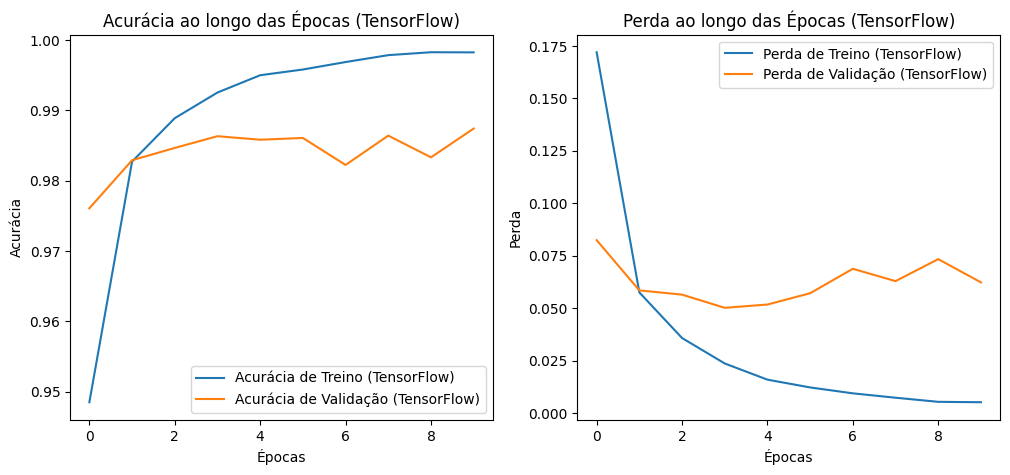

In [ ]:
import matplotlib.pyplot as plt


# TensorFlow - Acurácia e Perda
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_tf.history['accuracy'], label='Acurácia de Treino (TensorFlow)')
plt.plot(history_tf.history['val_accuracy'], label='Acurácia de Validação (TensorFlow)')
plt.title('Acurácia ao longo das Épocas (TensorFlow)')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_tf.history['loss'], label='Perda de Treino (TensorFlow)')
plt.plot(history_tf.history['val_loss'], label='Perda de Validação (TensorFlow)')
plt.title('Perda ao longo das Épocas (TensorFlow)')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.show()






## Exibindo a perda ao longo do treino/teste.

313/313 [==============================] - 4s 13ms/step


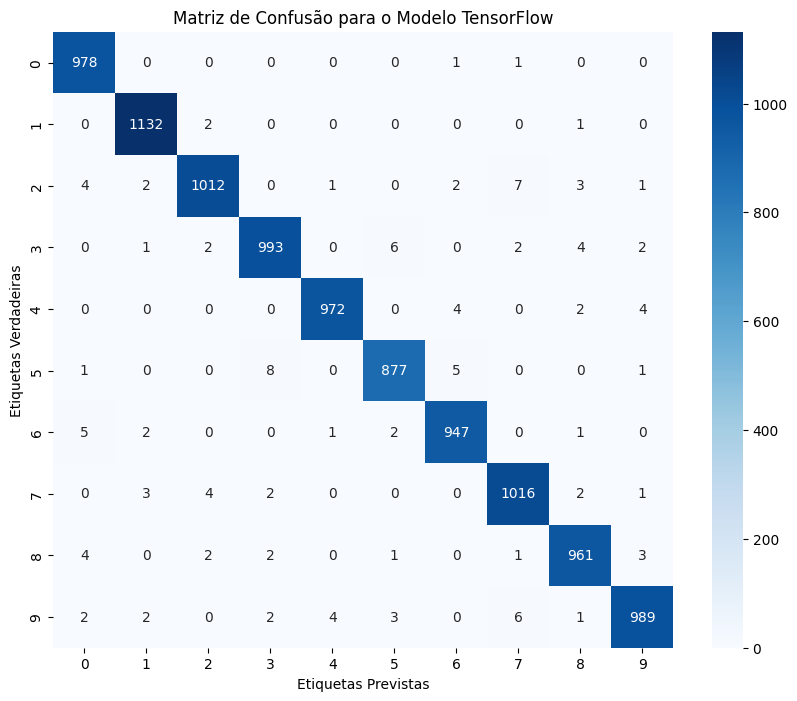

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# Previsões com o modelo TensorFlow
predictions_tf = model_tf.predict(test_images)
predicted_labels_tf = np.argmax(predictions_tf, axis=1)

# Matriz de confusão
conf_matrix_tf = confusion_matrix(test_labels, predicted_labels_tf)

# Visualização com Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_tf, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Etiquetas Previstas')
plt.ylabel('Etiquetas Verdadeiras')
plt.title('Matriz de Confusão para o Modelo TensorFlow')
plt.show()
